In [24]:
# Import libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


In [25]:
# Load datasets
training_data = pd.read_csv("/content/drive/MyDrive/Dataset/twitter_training.csv")  # Update path as needed
validation_data = pd.read_csv("/content/drive/MyDrive/Dataset/twitter_validation.csv")  # Update path as needed

In [26]:
# Rename columns for clarity
training_data.columns = ['id', 'entity', 'sentiment', 'text']
validation_data.columns = ['id', 'entity', 'sentiment', 'text']

In [27]:
def clean_text(text):
    if not isinstance(text, str):
        return ""  # Convert non-string entries to an empty string
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text.lower()

In [28]:
# Apply the cleaning function to both datasets
training_data['cleaned_text'] = training_data['text'].apply(clean_text)
validation_data['cleaned_text'] = validation_data['text'].apply(clean_text)

In [29]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(training_data['cleaned_text'])
X_test = vectorizer.transform(validation_data['cleaned_text'])
y_train = training_data['sentiment']
y_test = validation_data['sentiment']

In [30]:
# Train Naive Bayes Classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [31]:
# Predict on validation data
y_pred = classifier.predict(X_test)

In [32]:
# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6966966966966966
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.79      0.47      0.59       171
    Negative       0.63      0.84      0.72       266
     Neutral       0.79      0.57      0.66       285
    Positive       0.68      0.83      0.74       277

    accuracy                           0.70       999
   macro avg       0.72      0.68      0.68       999
weighted avg       0.72      0.70      0.69       999



In [33]:
# Add predictions to validation set for entity-based analysis
validation_data['predicted_sentiment'] = y_pred

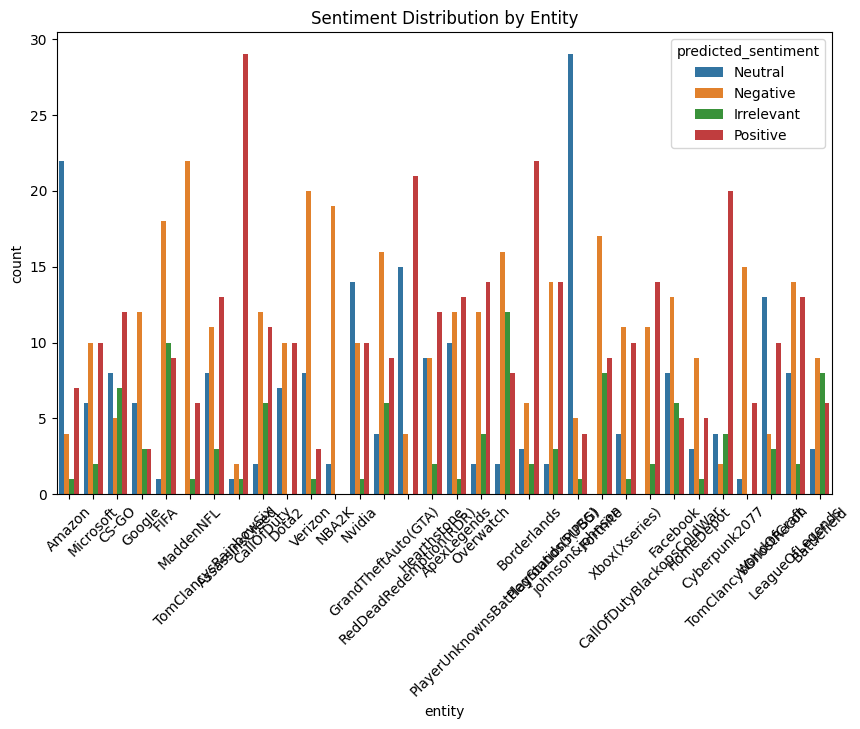

In [34]:
# Plot sentiment distribution by entity
plt.figure(figsize=(10, 6))
sns.countplot(data=validation_data, x='entity', hue='predicted_sentiment')
plt.title("Sentiment Distribution by Entity")
plt.xticks(rotation=45)
plt.show()

In [35]:
# 1. Sentiment Trends Over Time (if timestamp is available)
if 'timestamp' in validation_data.columns:
    validation_data['timestamp'] = pd.to_datetime(validation_data['timestamp'])
    validation_data['year_month'] = validation_data['timestamp'].dt.to_period('M')
    sentiment_trends = validation_data.groupby('year_month')['predicted_sentiment'].value_counts().unstack().fillna(0)

    # Plot sentiment trends over time
    sentiment_trends.plot(kind='line', figsize=(10, 6), title='Sentiment Trends Over Time')
    plt.ylabel('Count')
    plt.show()


In [36]:
# 2. Topic Modeling using LDA to identify key sentiment drivers
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(X_train)

In [37]:
# Visualizing the top words for each topic
feature_names = np.array(vectorizer.get_feature_names_out())
for index, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[-10:]]
    print(f"Topic {index}: {', '.join(top_words)}")

Topic 0: for, love, you, it, red, this, dead, and, to, the
Topic 1: for, is, my, that, of, johnson, in, and, to, the
Topic 2: in, this, it, is, my, and, game, to, of, the
Topic 3: just, and, good, shit, wtf, of, so, this, is, the
Topic 4: of, is, player, rhandlerr, and, unk, to, you, for, the


In [38]:
negative_feedback = validation_data[validation_data['predicted_sentiment'] == 'negative']
if negative_feedback.empty:
    print("No negative feedback found in the dataset.")
else:
    negative_words = ' '.join(negative_feedback['cleaned_text']).split()
    negative_words = ' '.join([word for word in negative_words if isinstance(word, str) and word.strip() != ''])

    # Proceed with generating WordCloud if negative words exist
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("WordCloud of Negative Sentiment Feedback")
    plt.axis('off')  # Turn off the axis
    plt.show()

No negative feedback found in the dataset.


In [39]:
# 4. Actionable Recommendations for Negative Sentiment
# Identifying specific aspects of negative feedback (e.g., 'customer support', 'delivery', 'product quality')
negative_feedback_text = ' '.join(negative_feedback['cleaned_text'])
aspect_keywords = ['customer service', 'delivery', 'quality', 'support', 'product', 'price']

In [40]:
# Analyzing the presence of aspect keywords in negative feedback
for aspect in aspect_keywords:
    if aspect in negative_feedback_text:
        print(f"Recommendation: Improve {aspect.capitalize()} based on frequent negative mentions.")

In [41]:
# 5. Sentiment Analysis by Entity (if multiple entities are present)
# Analyzing how sentiment differs by entity (brand/product, etc.)
sentiment_by_entity = validation_data.groupby('entity')['predicted_sentiment'].value_counts().unstack().fillna(0)

<Figure size 1200x800 with 0 Axes>

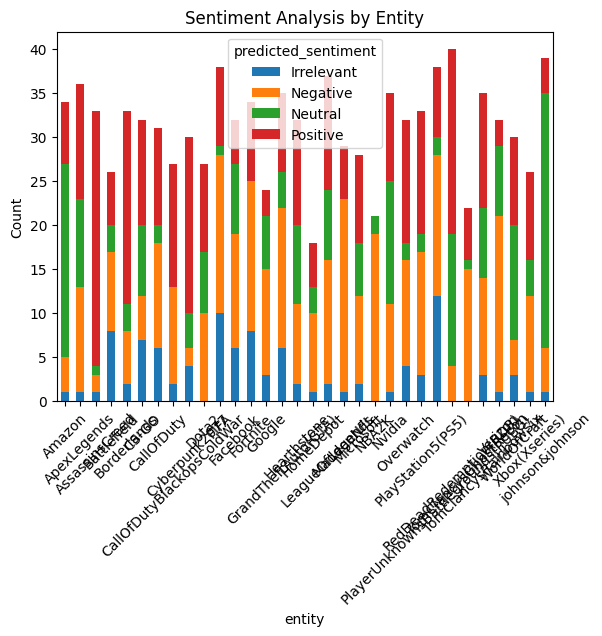

In [42]:
# Plotting the sentiment analysis by entity
plt.figure(figsize=(12, 8))
sentiment_by_entity.plot(kind='bar', stacked=True)
plt.title("Sentiment Analysis by Entity")
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [43]:
# 6. Sentiment Distribution Over Time (if timestamp is available)
if 'timestamp' in validation_data.columns:
    sentiment_by_time = validation_data.groupby(['year_month', 'predicted_sentiment']).size().unstack().fillna(0)

    # Plot sentiment distribution over time
    sentiment_by_time.plot(kind='line', figsize=(12, 8), title="Sentiment Distribution Over Time")
    plt.ylabel('Sentiment Count')
    plt.show()